# Classification 

This notebook is for use classifying each of the observed clusters according to the Trumplar system. This is done using three parameters. a) Range of Brightness b) Degree of Concertration c) Cluster Population. Firstly loading required packages and processed data.


In [560]:
import numpy as np 
import pandas as pd 
import os 
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns 
color_palette = sns.color_palette("plasma")

from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import dbscan
from sklearn.datasets import *
import hdbscan

from astropy import wcs
from astropy.stats import mad_std
from photutils import DAOStarFinder
from astropy.io import fits
from photutils import *
from astropy.coordinates import Angle, SkyCoord
from isochrones.mist import MIST_Isochrone
iso = MIST_Isochrone(bands=['B','V'])

Loading astrometric images and photometry parameters. 

In [561]:
file_list = sorted(glob.glob('astrometric_obs_data/*.fits'))
print(file_list)

['astrometric_obs_data/Bochum2_B_wcs.fits', 'astrometric_obs_data/Bochum2_V_wcs.fits', 'astrometric_obs_data/NGC2324_B_wcs.fits', 'astrometric_obs_data/NGC2324_V_wcs.fits', 'astrometric_obs_data/NGC2355_B_wcs.fits', 'astrometric_obs_data/NGC2355_V_wcs.fits', 'astrometric_obs_data/berkeley28_B_wcs.fits', 'astrometric_obs_data/berkeley28_V_wcs.fits']


In [562]:
photo_params = pd.read_csv('calibration_parameters/photo_params.csv') # - loading photometry parameters previously calculated. 
photo_params.head()

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [563]:
def lin_func(x, m, c): # - linear fit for magnitude calibration.
    return m*x + c 

mag_params = pd.read_csv('calibration_parameters/magnitude_processing/magnitude_cal.csv')

Loading previously defined star finder.

In [564]:
def starfinder(data, fwhm):
    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm, threshold = 5*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    return mst_sources

Also using previous method of wcs co-ordinates to find simlarities in detection. However, this section of script is edited to calcualte the distance of a detected star from the clusters known center. 

In [565]:
def common_sources(filename_V, filename_B, v_sources_raw, b_sources_raw):
    vhdulist = fits.open(filename_V)
    v_wcs = wcs.WCS(vhdulist[0].header)
    x_cordv = v_sources_raw['xcentroid']; y_cordv = v_sources_raw['ycentroid']
    v_cord = v_wcs.pixel_to_world(x_cordv, y_cordv)

    bhdulist = fits.open(filename_B)
    x_cordb = b_sources_raw['xcentroid']; y_cordb = b_sources_raw['ycentroid']
    b_wcs = wcs.WCS(bhdulist[0].header)
    b_cord = b_wcs.pixel_to_world(x_cordb, y_cordb)
    vcoord_index = []; bcoord_index = []

    v_idx = 0
    for cord in v_cord: 
        sep2tar = cord.separation(b_cord).degree
        if sep2tar.min() < 1.73e-3: 
            vcoord_index.append(v_idx)
            bcoord_index.append(np.argmin(sep2tar))
        v_idx += 1 

    v_sources = v_sources_raw[vcoord_index]; b_sources = b_sources_raw[bcoord_index]

    if len(v_sources) != len(b_sources):
        print('HALT!') 
    else: 
        print('Common Targets:', len(v_sources))

    center =  v_wcs.pixel_to_world(np.shape(vhdulist[0].data)[0]/2, np.shape(vhdulist[0].data)[1]/2)

    sep2cntr = []; v_cord = v_wcs.pixel_to_world(x_cordv[vcoord_index], y_cordv[vcoord_index])
    for star in v_cord: 
        sep2cntr.append(center.separation(star).degree)

    return v_sources, b_sources, np.array(sep2cntr), v_cord

Re-incorporating the script for photometry and doing the signal to noise calculation as per data analysis review. 

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

In [566]:
def aper_photometry(data, sources, aper, bkg_counts):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    # Aperture  
    aperture = CircularAperture(positions, r=aper)
    phot_table = aperture_photometry(data - bkg_counts, aperture)

    snr = np.array([])

    for col in phot_table.colnames[3:]:
        # bkg_total = bkg_counts*aperture.area
        net_star = phot_table[col] 
        snr = np.append(snr, net_star / np.sqrt(net_star))


    #- Now we get the final table of background subtracted counts for each star
    final_sum = phot_table['aperture_sum']

    return -2.5*np.log10(final_sum), snr

combing all the above steps in a unification function returns, 

In [567]:
def unifi_steps(filename_V, filename_B, table_index):

    data_B = fits.getdata(filename_B); data_V = fits.getdata(filename_V)
    fwhm_B = photo_params['FWHM_B'][table_index]; fwhm_V = photo_params['FWHM_V'][table_index]
    aper_B = photo_params['Aper_B'][table_index]; aper_V = photo_params['Aper_V'][table_index]
    bkg_B = photo_params['bkg_B'][table_index]; bkg_V = photo_params['bkg_V'][table_index]

    raw_B_sources = starfinder(data_B, fwhm_B) # returns list of sources from DAO. 
    raw_V_sources = starfinder(data_V, fwhm_V)

    fil_V_sources, fil_B_sources, seperation_values, target_coords = common_sources(filename_V, filename_B, raw_V_sources, raw_B_sources) # returns common sources between both B & V filters. 

    mag_V, snr_V = aper_photometry(data_V, fil_V_sources, aper_V, bkg_V)
    mag_B, snr_B = aper_photometry(data_B, fil_B_sources, aper_B, bkg_B)

    return mag_V, mag_B, snr_B, snr_V, fil_V_sources, fil_B_sources, seperation_values, target_coords

In [568]:
photo_params

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [569]:
mag_params

,target,slope,constant,slope_err,constant_err
0,berkeley28_B,0.971244,23.975025,0.021307,0.177514
1,berkeley28_V,1.001256,24.526199,0.005840,0.057108
2,Bochum2_B,1.020409,24.677540,0.010366,0.095138
3,Bochum2_V,1.045326,25.174370,0.015138,0.158771
4,NGC2324_B,0.987966,24.082465,0.014919,0.140935
5,NGC2324_V,1.103228,25.465649,0.001510,0.016055
6,NGC2355_B,1.015697,24.756676,0.005128,0.051794
7,NGC2355_V,1.085197,25.624728,0.012554,0.126313


This cluster was used for intial tests as it was the poorest documented of the clusters observed. Here error analysis and attempts to classify and fit isochrones.
The instrumental magnitudes were calibrated to the APASS9 catalog (Johnson filters)

$$ \sigma_y =  \sqrt{ x^2 \sigma^2_m + \sigma^2_C + 2x \sigma_m} $$ 

In [570]:
def covariance_propagation(x, slope_err, const_err): 
    return np.sqrt(x**2*slope_err**2 + const_err**2) #+ 2*x*slope_err)

## NGC 2324

Common Targets: 334


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Average seperation from the center 2.8406284980049334
2.7216342112001355


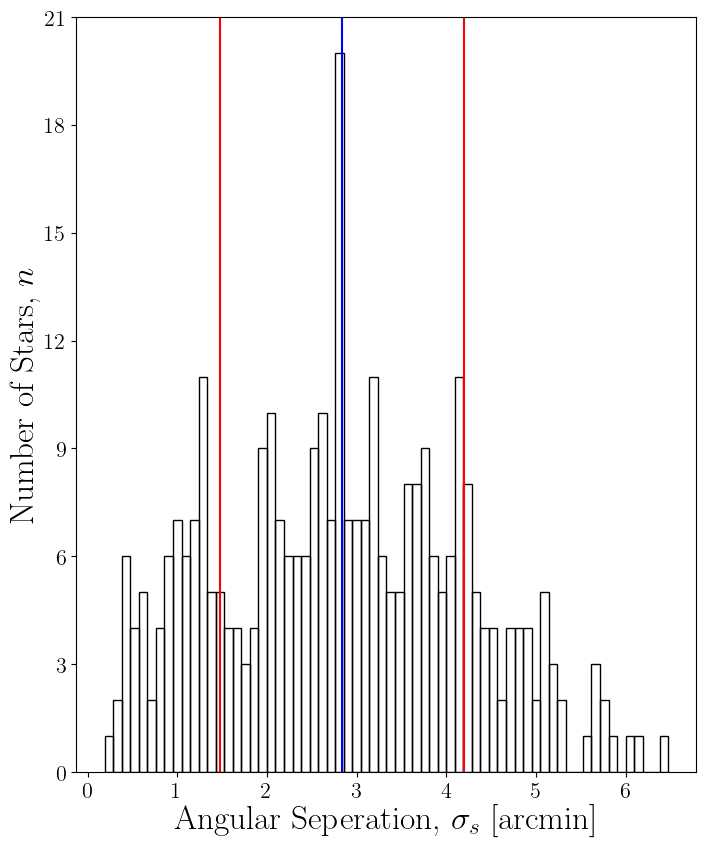

In [580]:
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/NGC2324_V_wcs.fits', 'astrometric_obs_data/NGC2324_B_wcs.fits', 1)

mag_Bc = lin_func(mag_B, mag_params['slope'][4], mag_params['constant'][4])
mag_Vc = lin_func(mag_V, mag_params['slope'][5], mag_params['constant'][5])

mag_V_err = covariance_propagation(mag_V, mag_params['slope_err'][1], mag_params['constant_err'][1])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]

data = pd.DataFrame({'mag_B': mag_Bc, 'emag_B':abs(1/snr_B)[nan_mask], 'mag_V':mag_Vc, 'emag_V':abs(1/snr_V)[nan_mask]})
data.to_csv('calibrated_mags/berkeley28.csv')

print('Average seperation from the center', seperation.mean()*60)

ax = plt.figure(figsize=(8, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.axvline(seperation.mean()*60, color = 'blue')
plt.axvline(seperation.mean()*60 + seperation.std()*60, color = 'red'); plt.axvline(seperation.mean()*60 - seperation.std()*60, color = 'red')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
print(seperation.std()*2*60)

In [581]:
clus_size = int(.05*len(mag_Vc))
cmd_data = np.transpose(np.array([mag_Vc, (mag_Bc - mag_Vc)]))

# -- DBSCAN Calculation -- 
preds = dbscan(cmd_data, .5, clus_size)[1]
dbscanned_data = np.append(cmd_data, preds.reshape(-1,1), axis=1)
scanned_dataframe = pd.DataFrame(dbscanned_data); scanned_dataframe = scanned_dataframe.rename(columns={0: "V_mag", 1: "BV_mag", 2: "cluster_no"})

print('Unique Clusters found', len(np.unique(scanned_dataframe['cluster_no'])))

for i in np.unique(scanned_dataframe['cluster_no']): 
    count = np.count_nonzero(scanned_dataframe['cluster_no'] == i)
    print(i, ':', count)

Unique Clusters found 2
-1.0 : 15
0.0 : 316


/Library/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass min_samples=16 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [582]:
cmd_data = np.transpose(np.array([mag_Vc, (mag_Bc - mag_Vc)]))

clusterer = hdbscan.HDBSCAN(min_cluster_size = clus_size).fit(cmd_data)
grouping = clusterer.labels_
probablities = clusterer.probabilities_

print('Unique clusters found:', len(np.unique(grouping)))
print('Respective sizes: \n ---')

for i in np.unique(grouping): 
    count = np.count_nonzero(grouping == i)
    print(i, ':', count)

# print('\n --- \n Probablities: \n', probablities)

Unique clusters found: 3
Respective sizes: 
 ---
-1 : 219
0 : 93
1 : 19


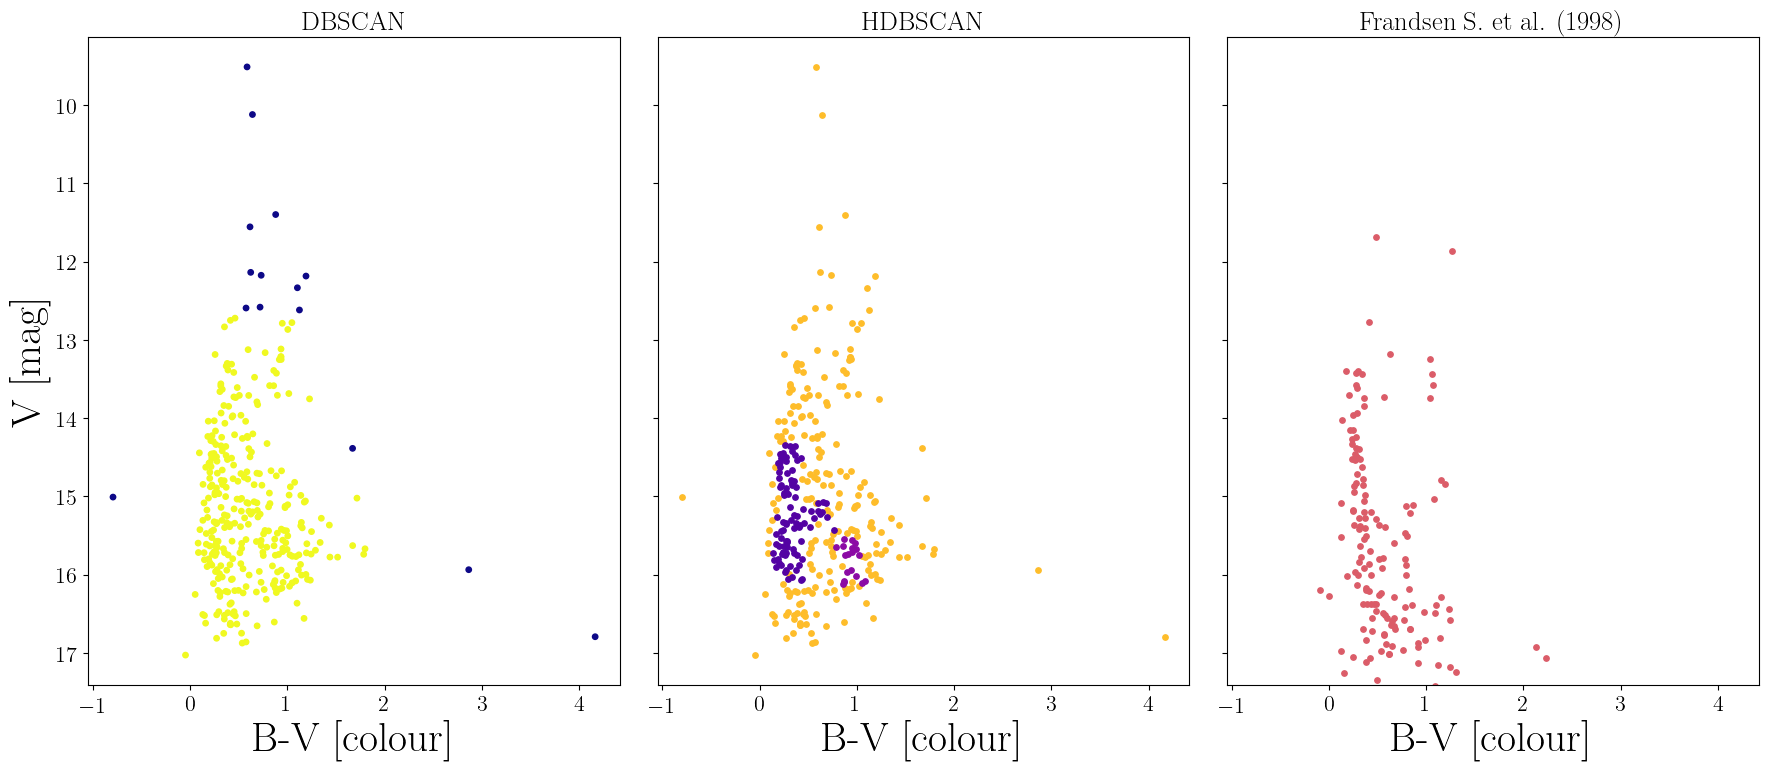

In [583]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8), dpi = 100)

dot_size = 15

# fig.suptitle('Population Determination Comparison: NGC 2324')

# --- DBScan Plot --- 
ax1.scatter(scanned_dataframe['BV_mag'], scanned_dataframe['V_mag'], c = scanned_dataframe['cluster_no'], label = scanned_dataframe['cluster_no'], cmap = 'plasma', s = dot_size)
y_low, y_high = ax1.get_ylim(); x_low, x_high = ax1.get_xlim()
ax1.set_title('DBSCAN')
ax1.set_ylabel('V [mag]')


# --- HDBScan Plot --- 
c = 0
for i in np.unique(grouping):
    cluster_mask = np.where(grouping == i)
    ax2.scatter((mag_Bc - mag_Vc)[cluster_mask], mag_Vc[cluster_mask], s = dot_size, color = color_palette[i])
    c += 1
ax2.set_title('HDBSCAN')


# --- Archived Data Plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/NGC2324_WEBDA.txt', usecols = (2, 3), unpack = True)
ax3.scatter(webda_BV, webda_V, s = dot_size, color = color_palette[3])
ax3.set_xlim(x_low, x_high); ax3.set_ylim(y_low, y_high)
ax3.set_title('Frandsen S. et al. (1998)')


for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlabel('B-V [colour]')
    ax.invert_yaxis()

plt.tight_layout()

## Gaia Comparison 

In [575]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [585]:
gaia_data = pd.read_csv('gaia_cluster_populations/NGC2324.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 1e-3: 
            matching_mags.append(i)
            
gaia_matched_B = mag_Bc[matching_mags]
# gaia_matched_V = mag_Vc[matching_mags]
print('\n This works:', len(gaia_matched_B), '\n 2021 Study: 242')
gaia_data.head()


 This works: 251 
 2021 Study: 242


,Unnamed: 0,RA_ICRS,DE_ICRS,e_RA_ICRS,e_DE_ICRS,mem_prob
0,0,106.008380,0.881757,0.2498,0.2384,1.000000
1,9,105.995933,0.893122,0.3791,0.4108,0.917581
2,10,105.999244,0.891119,0.1975,0.1847,1.000000
3,11,105.996237,0.886948,0.2556,0.2401,1.000000
4,13,106.001857,0.884655,0.4064,0.4229,1.000000


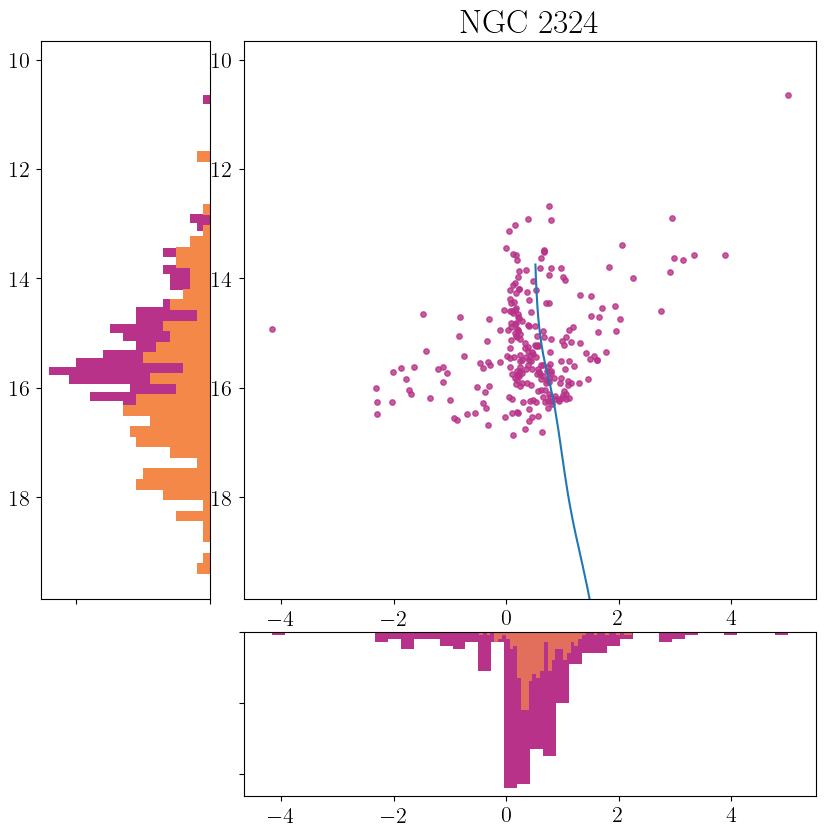

In [586]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True 
plt.rcParams['font.size'] = '16'

# the data 
y = gaia_matched_V[~np.isnan(gaia_matched_B)]
x = (gaia_matched_B - gaia_matched_V)[~np.isnan(gaia_matched_B)]

# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 10), dpi = 100)
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)


# isochrone fitting 
isochrone = iso.isochrone(age = 8.65, feh = -0.52)


modelv = isochrone['V_mag'] + 13.1
modelbv = (isochrone['B_mag'] - isochrone['V_mag']) + .627
main_ax.plot(modelbv, modelv)

# scatter points on the main axes

main_ax.scatter(x, y, color = color_palette[2], s=dot_size, alpha=0.8)
# main_ax.scatter(webda_BV, webda_V, color = color_palette[3], s=dot_size, alpha=0.8)
x_low, x_high = ((x.min() - 0.5), (x.max() + 0.5)); y_low, y_high = ((y.min() - 1), (y.max() + 3))

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2])
x_hist.hist(webda_BV, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[4], alpha = 0.7)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2])
y_hist.hist(webda_V, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[4])
y_hist.invert_xaxis()

main_ax.set_title('NGC 2324', fontsize = 24)
main_ax.set_xlim(x_low, x_high); main_ax.set_ylim(y_low, y_high)
# main_ax.set_xticks([])
# main_ax.set_yticks([])
main_ax.invert_yaxis()
plt.show()

# NGC 2355

In [595]:
# --- Loading Data and CMD --- 
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/NGC2355_V_wcs.fits', 'astrometric_obs_data/NGC2355_B_wcs.fits', 3)

mag_Bc = lin_func(mag_B, mag_params['slope'][6], mag_params['constant'][6])
mag_Vc = lin_func(mag_V, mag_params['slope'][7], mag_params['constant'][7])

mag_V_err = covariance_propagation(mag_V, mag_params['slope_err'][3], mag_params['constant_err'][3])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]

data = pd.DataFrame({'mag_B': mag_Bc, 'emag_B':abs(1/snr_B)[nan_mask], 'mag_V':mag_Vc, 'emag_V':abs(1/snr_V)[nan_mask]})
data.to_csv('calibrated_mags/berkeley28.csv')

print('Average seperation from the center', seperation.mean()*60)

gaia_data = pd.read_csv('gaia_cluster_populations/NGC2355.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 20e-3: 
            matching_mags.append(i)
            
gaia_matched_B = mag_Bc[matching_mags]
gaia_matched_V = mag_Vc[matching_mags]
print('\n This works:', len(gaia_matched_B), '\n 2021 Study: 261')
gaia_data.head()


# --- Archived Data for the plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/NGC2324_WEBDA.txt', usecols = (2, 3), unpack = True)


# --- Plotting Isochrone and CMD --- 
y = gaia_matched_V
x = (gaia_matched_B - gaia_matched_V)

# - Setting up grid for multi-histogram plot -
fig = plt.figure(figsize=(10, 10), dpi = 100)
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)


# - Intialising and Fitting Isochrone 
isochrone = iso.isochrone(age = 8.65, feh = -0.52)
modelv = isochrone['V_mag'] + 13.1
modelbv = (isochrone['B_mag'] - isochrone['V_mag']) + .627
main_ax.plot(modelbv, modelv)

# scatter points on the main axes

main_ax.scatter(x, y, color = color_palette[2], s=dot_size, alpha=0.8)
# main_ax.scatter(webda_BV, webda_V, color = color_palette[3], s=dot_size, alpha=0.8)
x_low, x_high = ((x.min() - 0.5), (x.max() + 0.5)); y_low, y_high = ((y.min() - 1), (y.max() + 3))

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2])
x_hist.hist(webda_BV, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[4], alpha = 0.7)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2])
y_hist.hist(webda_V, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[4])
y_hist.invert_xaxis()

main_ax.set_title('NGC 2324', fontsize = 24)
main_ax.set_xlim(x_low, x_high); main_ax.set_ylim(y_low, y_high)
# main_ax.set_xticks([])
# main_ax.set_yticks([])
main_ax.invert_yaxis()
plt.show()

Common Targets: 211


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Average seperation from the center 2.7577813250835517

 This works: 209 
 2021 Study: 261


,Unnamed: 0,RA_ICRS,DE_ICRS,e_RA_ICRS,e_DE_ICRS,mem_prob
0,1,109.232014,13.615016,0.0213,0.0191,0.653191
1,7,109.247346,13.624913,0.2255,0.1990,0.683632
2,9,109.256378,13.619696,0.1186,0.1116,0.987663
3,10,109.265810,13.613109,0.5702,0.4927,1.000000
4,19,109.211012,13.611194,0.1659,0.1465,0.766160
